In [72]:
import numpy as np

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import math

In [3]:
data2003 = pd.read_csv("Downloads/2003.csv")
data2004 = pd.read_csv("Downloads/2004.csv")
data2005 = pd.read_csv("Downloads/2005.csv")
data2006 = pd.read_csv("Downloads/2006.csv")
data2007 = pd.read_csv("Downloads/2007.csv")
data2008 = pd.read_csv("Downloads/2008.csv")

/Users/leva94/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data = pd.concat([data2003, data2004, data2005, data2006, data2007, data2008])

In [5]:
data.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [6]:
data["UniqueCarrier"].value_counts()

WN    6454950
AA    4006697
DL    3440463
OO    3090853
MQ    3025493
UA    3025212
US    2701364
NW    2682336
XE    2350309
CO    1829727
EV    1697172
OH    1464176
FL    1265138
AS     957377
YV     854056
B6     811341
DH     693047
HP     583311
9E     521059
F9     336958
HA     274265
TZ     208420
AQ      89547
Name: UniqueCarrier, dtype: int64

In [171]:
data_work = data.loc[data["UniqueCarrier"] == "CO"][["Origin", "Dest"]]

In [172]:
data_work["Flight"] = data_work["Origin"] + data_work["Dest"]

In [173]:
final = data_work["Flight"].value_counts()

In [174]:
final.to_csv("continental.csv", sep=',', encoding='utf-8')

In [175]:
final

BOSEWR    22751
EWRBOS    22348
IAHLAX    21956
EWRIAH    21787
MSYIAH    21767
IAHMSY    21754
LAXIAH    21726
IAHEWR    21198
IAHSAT    21069
SATIAH    21066
IAHAUS    20782
AUSIAH    20771
EWRMCO    19437
MCOEWR    19433
LGAIAH    19358
IAHLGA    19308
FLLEWR    16858
EWRFLL    16825
IAHDCA    16180
DCAIAH    16156
EWRATL    15382
ATLEWR    15349
IAHLAS    15281
IAHORD    15206
LASIAH    15135
ORDIAH    15105
DENIAH    15099
ORDEWR    14982
IAHDEN    14973
EWRORD    14881
          ...  
IAHCVG        1
SJCSAN        1
ORDCLE        1
SEAPDX        1
CLEMKE        1
MIAIND        1
LAXCMH        1
SEAMSY        1
SDFBOS        1
BHMEWR        1
LAXSDF        1
MDWCLE        1
PHLJAX        1
BWIEWR        1
LAXIND        1
SJCSFO        1
LBBIAH        1
SFOSAN        1
IAHCHS        1
SDFSMF        1
BOSSDF        1
EWRPHL        1
MSYSEA        1
SNACLE        1
MKECLE        1
INDLAX        1
MKEMDW        1
ORDMDW        1
LGAJAX        1
MSYCMH        1
Name: Flight, Length: 45

In [74]:
data_short = pd.read_csv("whole_data.csv", sep=",", names=["Flight", "Quantity"])

In [76]:
data_short["ORIGIN"] = data_short["Flight"].apply(lambda x: x[0:3])
data_short["DESTINATION"] = data_short["Flight"].apply(lambda x: x[3:6])

In [78]:
air_info = data_short.groupby("ORIGIN")["Quantity"].sum() + data_short.groupby("DESTINATION")["Quantity"].sum()

In [81]:
largest_airports = air_info.nlargest(100).index

In [83]:
matrix = pd.DataFrame(0, index=largest_airports, columns=largest_airports)

In [84]:
for i in range(7242):
    if data_short["ORIGIN"][i] in list(largest_airports):
        if data_short["DESTINATION"][i] in list(largest_airports):
            matrix[data_short["ORIGIN"][i]][data_short["DESTINATION"][i]] += data_short["Quantity"][i]
            matrix[data_short["DESTINATION"][i]][data_short["ORIGIN"][i]] += data_short["Quantity"][i]

In [85]:
class Graph:
    def __init__(self, incidence_matrix):
        self.incidence_matrix = pd.DataFrame(np.array(incidence_matrix), 
                                             index=incidence_matrix.index, columns=incidence_matrix.columns)
        self.prec = pd.Series("", index=incidence_matrix.index)
        self.time_in = pd.Series(-1, index=incidence_matrix.index)
        succlist = []
        for i in incidence_matrix.index:
            succlist.append([])
        self.succ = pd.Series(succlist, index=incidence_matrix.index)
        self.ret = pd.Series(-1, index=incidence_matrix.index)
        self.tight_component = pd.Series(-1, index=incidence_matrix.index)
        self.cur_time = -1
        self.bridges = []
        self.most_popular_dests = []
        
    def reinit(self):
        self.prec = pd.Series("", index=self.incidence_matrix.index)
        self.time_in = pd.Series(-1, index=self.incidence_matrix.index)
        succlist = []
        for i in self.incidence_matrix.index:
            succlist.append([])
        self.succ = pd.Series(succlist, index=self.incidence_matrix.index)
        self.ret = pd.Series(-1, index=self.incidence_matrix.index)
        self.tight_component = pd.Series(-1, index=self.incidence_matrix.index)
        self.cur_time = -1
        self.bridges = []
        
    def find_popular_dests(self):
        the_matrix = pd.DataFrame(np.array(self.incidence_matrix), 
                                    index=self.incidence_matrix.index, columns=self.incidence_matrix.columns)
        maxx = 200000
        list_of_dests = []
        while (maxx > 40000):
            max_origin = the_matrix.max().idxmax()
            max_dest = the_matrix[max_origin].idxmax()
            maxx = the_matrix[max_origin][max_dest]
            the_matrix[max_origin][max_dest] = -maxx
            the_matrix[max_dest][max_origin] = -maxx
            list_of_dests.append([max_origin, max_dest, maxx])
        graph.most_popular_dests = pd.DataFrame(list_of_dests)
        return pd.DataFrame(list_of_dests)
        
    def dfs(self, min_flights, airport):
        for dest in self.incidence_matrix.index:
            if (self.incidence_matrix[airport][dest] >= min_flights):
                if (self.prec[dest] == ""):
                    self.cur_time += 1
                    self.time_in[dest] = self.cur_time
                    self.ret[dest] = self.cur_time
                    self.prec[dest] = airport
                    self.succ[airport].append(dest)
                    self.dfs(min_flights, dest)
        
    def BIG_DFS(self, min_flights):
        for ap in self.incidence_matrix.index:
            if (self.prec[ap] == ""):
                self.prec[ap] = ap
                self.cur_time += 1
                self.time_in[ap] = self.cur_time
                self.ret[ap] = self.cur_time
                self.dfs(min_flights, ap)
        return self.time_in
    
    def count_return(self, ap, min_flights):
        for dest in self.succ[ap]:
            self.count_return(dest, min_flights)
            if (self.ret[dest] < self.ret[ap]):
                self.ret[ap] = self.ret[dest]
        for dest in self.incidence_matrix.index:
            if (self.incidence_matrix[dest][ap] >= min_flights):
                if (dest != self.prec[ap]):
                    if (self.time_in[dest] < self.ret[ap]):
                        self.ret[ap] = self.time_in[dest]
                    
    def COUNT_RETURNS(self, min_flights):
        for airport in self.incidence_matrix.index:
            if (self.prec[airport] == airport):
                self.count_return(airport, min_flights)
    
    def find_tight_component(self, vertex, marker):
        self.tight_component[vertex] = marker
        for dest in self.succ[vertex]:
            if (self.ret[dest] > self.time_in[vertex]):
                self.prec[dest] = dest
                self.bridges.append([vertex, dest])
            else:
                self.find_tight_component(dest, marker)
    
    def TIGHT_COMPONENTS_SPLIT(self, min_flights):
        self.BIG_DFS(min_flights)
        self.COUNT_RETURNS(min_flights)
        marker = -1
        while ((self.tight_component == -1).any()):
            for city in self.incidence_matrix.index:
                if (self.tight_component[city] == -1):
                    if (self.prec[city] == city):
                        marker +=1
                        self.find_tight_component(city, marker)
        return self.tight_component
    
    def GAMMA_ALGORITHM(self, min_flights, component_marker):
        list_of_cities = []
        for city in self.incidence_matrix.index:
            if (self.tight_component[city] == component_marker):
                list_of_cities.append(city)
        if (len(list_of_cities) < 2):
            return True
        component_matrix = self.incidence_matrix[list_of_cities].loc[list_of_cities]
        component_matrix = (component_matrix >= min_flights)
        written_cities = pd.Series(False, index=list_of_cities)
        stack_of_cities = []
        stack_of_cities.append(list_of_cities[0])
        while (len(stack_of_cities) < len(list_of_cities) + 1):
            for city in list_of_cities:
                if (component_matrix[city][stack_of_cities[-1]]):
                    if (len(stack_of_cities) == 1):
                        stack_of_cities.append(city)
                    else:
                        if (city != stack_of_cities[-2]):
                            stack_of_cities.append(city)
        begin = -1
        end = len(stack_of_cities)
        for i in range(len(stack_of_cities)):
            for j in range(i+1, end, 1):
                if (stack_of_cities[i] == stack_of_cities[j]):
                    if (j < end):
                        begin = i
                        end = j
        list_of_faces = []
        face = []
        for i in range(begin, end):
            face.append(stack_of_cities[i])
            component_matrix[stack_of_cities[i]][stack_of_cities[i+1]] = False
            component_matrix[stack_of_cities[i+1]][stack_of_cities[i]] = False
            written_cities[stack_of_cities[i]] = True
        list_of_faces.append(face)
        list_of_faces.append(face)
        while (component_matrix.any().any()):
            set_of_segments = []
            interior_matrix = component_matrix.loc[written_cities, written_cities]
            if (interior_matrix.any().any()):
                for city in interior_matrix.index:
                    for dest in interior_matrix.index:
                        if (interior_matrix[city][dest] & (city > dest)):
                            set_of_vertices = set([])
                            set_of_adjacent = set([city, dest])
                            faces_to_add = []
                            gamma = 0
                            for i in range(len(list_of_faces)):
                                if set_of_adjacent.issubset(set(list_of_faces[i])):
                                    gamma +=1
                                    faces_to_add.append(i)
                            set_of_segments.append((set_of_vertices, set_of_adjacent, gamma, faces_to_add))
            if (not (written_cities.all())):
                rest_matrix = component_matrix.loc[-written_cities, -written_cities]
                segment_markers = pd.Series(-1, index=rest_matrix.index)
                marker = 0
                segment_markers[rest_matrix.index[0]] = 0
                while ((segment_markers == -1).any()):
                    if (rest_matrix.loc[segment_markers == marker, segment_markers != marker].any().any()):
                        for city in segment_markers.index:
                            if (segment_markers[city] == marker):
                                for dest in segment_markers.index:
                                    if (rest_matrix[city][dest]):
                                        segment_markers[dest] = marker
                    else:
                        marker +=1
                        control = True
                        for city in segment_markers.index:
                            if (segment_markers[city] == -1):
                                if (control):
                                    segment_markers[city] = marker
                                    control = False
                for i in range(marker+1):
                    set_of_vertices = set([])
                    set_of_adjacent = set([])
                    for city in segment_markers.index:
                        if (segment_markers[city] == i):
                            set_of_vertices.add(city)
                            for dest in interior_matrix.index:
                                if component_matrix[city][dest]:
                                    set_of_adjacent.add(dest)
                    faces_to_add = []
                    gamma = 0
                    for i in range(len(list_of_faces)):
                        if set_of_adjacent.issubset(set(list_of_faces[i])):
                            gamma +=1
                            faces_to_add.append(i)
                    set_of_segments.append((set_of_vertices, set_of_adjacent, gamma, faces_to_add))
            min_segment = (set([]), set([]), 100 * len(component_matrix.index), [])
            for segment in set_of_segments:
                if (segment[2] < min_segment[2]):
                    min_segment = segment
            if (min_segment[2] == 0):
                return False
            list_of_adjacent = list(min_segment[1])
            if (len(list_of_adjacent) == 1):
                first_vertex = ""
                second_vertex = ""
                for city in min_segment[0]:
                    if (component_matrix[list_of_adjacent[0]][city]):
                        if (first_vertex == ""):
                            first_vertex = city
                        else:
                            if (second_vertex == ""):
                                second_vertex = city
                component_matrix[list_of_adjacent[0]][first_vertex] = False
                component_matrix[first_vertex][list_of_adjacent[0]] = False
                component_matrix[list_of_adjacent[0]][second_vertex] = False
                component_matrix[second_vertex][list_of_adjacent[0]] = False
                visited = pd.Series(False, index=min_segment[0])
                visited[first_vertex] = True
                stack_of_vertices = [first_vertex]
                path = []
                while (len(stack_of_vertices) > 0):
                    current = stack_of_vertices[-1]
                    if (current == second_vertex):
                        path = list(stack_of_vertices)
                    for dest in min_segment[0]:
                        if (current == stack_of_vertices[-1]):
                            if (component_matrix[current][dest]):
                                if (not visited[dest]):
                                    stack_of_vertices.append(dest)
                                    visited[dest] = True
                    if (current == stack_of_vertices[-1]):
                        stack_of_vertices.pop()
                for i in range(len(path) - 1):
                    component_matrix[path[i]][path[i+1]] = False
                    component_matrix[path[i+1]][path[i]] = False
                for i in range(len(path)):
                    written_cities[path[i]] = True
                path.append(list_of_adjacent[0])
                Face = list(list_of_faces[min_segment[3][0]])
                index = Face.index(list_of_adjacent[0]) + 1
                list_of_faces[min_segment[3][0]] = Face[:index]
                list_of_faces[min_segment[3][0]].extend(path)
                list_of_faces[min_segment[3][0]].extend(Face[index:])
                list_of_faces.append(path)
            else:
                path = []
                list_of_adjacent = list(min_segment[1])
                if (len(min_segment[0]) != 0):
                    first_vertex = ""
                    second_vertex = ""
                    for city in min_segment[0]:
                        if (component_matrix[list_of_adjacent[0]][city]):
                            if (first_vertex == ""):
                                first_vertex = city
                        if (component_matrix[list_of_adjacent[1]][city]):
                            if (second_vertex == ""):
                                second_vertex = city
                    component_matrix[list_of_adjacent[0]][first_vertex] = False
                    component_matrix[first_vertex][list_of_adjacent[0]] = False
                    component_matrix[list_of_adjacent[1]][second_vertex] = False
                    component_matrix[second_vertex][list_of_adjacent[1]] = False
                    visited = pd.Series(False, index=min_segment[0])
                    visited[first_vertex] = True
                    stack_of_vertices = [first_vertex]
                    while (len(stack_of_vertices) > 0):
                        current = stack_of_vertices[-1]
                        if (current == second_vertex):
                            path = list(stack_of_vertices)
                        for dest in min_segment[0]:
                            if (current == stack_of_vertices[-1]):
                                if (component_matrix[current][dest]):
                                    if (not visited[dest]):
                                        stack_of_vertices.append(dest)
                                        visited[dest] = True
                        if (current == stack_of_vertices[-1]):
                            stack_of_vertices.pop()
                        for i in range(len(path) - 1):
                            component_matrix[path[i]][path[i+1]] = False
                            component_matrix[path[i+1]][path[i]] = False
                        for i in range(len(path)):
                            written_cities[path[i]] = True
                else:
                    component_matrix[list_of_adjacent[0]][list_of_adjacent[1]] = False
                    component_matrix[list_of_adjacent[1]][list_of_adjacent[0]] = False
                reverse_path = list(path)
                reverse_path.reverse()
                Face = list(list_of_faces[min_segment[3][0]])
                first_index = Face.index(list_of_adjacent[0])
                second_index = Face.index(list_of_adjacent[1])
                if (first_index < second_index):
                    list_of_faces[min_segment[3][0]] = Face[first_index : second_index + 1]
                    list_of_faces[min_segment[3][0]].extend(reverse_path)
                    new_face = Face[: first_index + 1]
                    new_face.extend(path)
                    new_face.extend(Face[second_index :])
                else:
                    list_of_faces[min_segment[3][0]] = Face[second_index : first_index + 1]
                    list_of_faces[min_segment[3][0]].extend(path)
                    new_face = Face[: second_index + 1]
                    new_face.extend(reverse_path)
                    new_face.extend(Face[first_index :])
                list_of_faces.append(new_face)    
        return list_of_faces

In [86]:
graph = Graph(matrix)

In [87]:
graph.reinit()

In [177]:
graph.find_popular_dests()

,0,1,2
0,LAX,SAN,167608
1,BOS,LGA,151429
2,LAX,LAS,150846
3,LGA,DCA,145828
4,ORD,LGA,134538
5,PHX,LAS,131920
6,LAX,PHX,129923
7,ORD,MSP,126960
8,ATL,DFW,123697
9,LAX,SFO,123421


In [89]:
for i in range(len(graph.most_popular_dests) - 1):
    print(i)
    graph.reinit()
    graph.TIGHT_COMPONENTS_SPLIT(graph.most_popular_dests[2][i])
    for j in range(100):
        if (graph.GAMMA_ALGORITHM(graph.most_popular_dests[2][i], j) == False):
            graph.incidence_matrix[graph.most_popular_dests[0][i]][graph.most_popular_dests[1][i]] = 0
            graph.incidence_matrix[graph.most_popular_dests[1][i]][graph.most_popular_dests[0][i]] = 0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238


In [90]:
graph.reinit()
graph.TIGHT_COMPONENTS_SPLIT(graph.most_popular_dests[2][len(graph.most_popular_dests) - 2])
target_split = graph.GAMMA_ALGORITHM(graph.most_popular_dests[2][len(graph.most_popular_dests) - 2], 0)

In [91]:
set_of_cities = set([])
for i in range(len(target_split)):
    for j in range(len(target_split[i])):
        set_of_cities.add(target_split[i][j])

In [92]:
target_matrix = graph.incidence_matrix.loc[set_of_cities, set_of_cities] >= 40000

In [93]:
for face in target_split:
    while (len(face) > 3):
        if (target_matrix[face[0]][face[2]]):
            target_matrix[face[1]][face[3]] = True
            target_matrix[face[3]][face[1]] = True
            target_split.append([face[1], face[2], face[3]])
            face.remove(face[2])
        else:
            target_matrix[face[0]][face[2]] = True
            target_matrix[face[2]][face[0]] = True
            target_split.append([face[1], face[2], face[0]])
            face.remove(face[1])

In [94]:
outer_face = frozenset(target_split[0])
number_of_faces = len(target_split[1:])
inner_faces = dict()
for face in target_split[1:]:
    inner_faces[frozenset(face)] = 1
secondary_cities = []
while ((target_matrix.sum().min() < 4) & (len(target_matrix) > 3)):
    rem_city = target_matrix.sum().idxmin()
    adjacent_cities = list(target_matrix[rem_city][target_matrix[rem_city]].index)
    faces_to_remove = []
    faces_to_remove.append(frozenset([adjacent_cities[0], adjacent_cities[1], rem_city]))
    faces_to_remove.append(frozenset([adjacent_cities[0], adjacent_cities[2], rem_city]))
    faces_to_remove.append(frozenset([adjacent_cities[1], adjacent_cities[2], rem_city]))
    weight_face = pd.Series(0, index=adjacent_cities)
    if (rem_city in outer_face):
        old_number = number_of_faces
        for face in faces_to_remove:
            if (face == outer_face):
                outer_face = frozenset(adjacent_cities)
                for city in adjacent_cities:
                    if (not (city in face)):
                        weight_face[city] = old_number
            else:
                for city in adjacent_cities:
                    if (not (city in face)):
                        weight = inner_faces.pop(face)
                        weight_face[city] = -weight
                        number_of_faces -= weight
    else:
        for face in faces_to_remove:
            for city in adjacent_cities:
                if (not (city in face)):
                    weight_face[city] = inner_faces.pop(face)
        inner_faces[frozenset(adjacent_cities)] = weight_face.sum()
    target_matrix = target_matrix.drop([rem_city], axis=0)
    target_matrix = target_matrix.drop([rem_city], axis=1)
    secondary_cities.append([rem_city, weight_face])

In [95]:
X = pd.Series(0, index=target_matrix.index, dtype=float)
Y = pd.Series(0, index=target_matrix.index, dtype=float)
X[list(outer_face)[1]] = 1
X[list(outer_face)[2]] = 2
Y[list(outer_face)[1]] = 2

In [96]:
def area(face, X, Y):
    return 0.5 * np.abs((X[face[1]] - X[face[0]]) * (Y[face[2]] - Y[face[0]]) - (X[face[2]] - X[face[0]]) * (Y[face[1]] - Y[face[0]]))

In [97]:
faces_to_move = list(inner_faces.keys())

In [98]:
weight = (1 / target_matrix.sum(1))
target_matrixx = target_matrix.drop(outer_face, axis=1)
for iterr in range(1000):
    if (iterr % 10 == 0):
        print(iterr)
        total_area = 0
        for face in faces_to_move:
            total_area += area(list(face), X, Y)
        print(total_area - 2.0)
    for city in target_matrixx.columns:
        X[city] = 0.2 * (X[target_matrixx[city]] * weight[target_matrixx[city]]).mean() / weight[target_matrixx[city]].mean() + 0.8 * X[city]
        Y[city] = 0.2 * (Y[target_matrixx[city]] * weight[target_matrixx[city]]).mean() / weight[target_matrixx[city]].mean() + 0.8 * Y[city]

0
0.0
10
0.0
20
0.0
30
0.0
40
0.0
50
0.0
60
0.0
70
0.0
80
0.0
90
0.0
100
0.0
110
0.0
120
0.0
130
0.0
140
0.0
150
0.0
160
0.0
170
0.0
180
0.0
190
0.0
200
0.0
210
0.0
220
0.0
230
0.0
240
0.0
250
0.0
260
0.0
270
0.0
280
0.0
290
0.0
300
0.0
310
0.0
320
0.0
330
0.0
340
0.0
350
0.0
360
0.0
370
0.0
380
0.0
390
0.0
400
0.0
410
0.0
420
0.0
430
0.0
440
0.0
450
0.0
460
0.0
470
0.0
480
0.0
490
0.0
500
0.0
510
0.0
520
0.0
530
0.0
540
0.0
550
0.0
560
0.0
570
0.0
580
0.0
590
0.0
600
0.0
610
0.0
620
0.0
630
0.0
640
0.0
650
0.0
660
0.0
670
0.0
680
0.0
690
0.0
700
0.0
710
0.0
720
0.0
730
0.0
740
0.0
750
0.0
760
0.0
770
0.0
780
0.0
790
0.0
800
0.0
810
0.0
820
0.0
830
0.0
840
0.0
850
0.0
860
0.0
870
0.0
880
0.0
890
0.0
900
0.0
910
0.0
920
0.0
930
0.0
940
0.0
950
0.0
960
0.0
970
0.0
980
0.0
990
0.0


In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

In [102]:
secondary_cities.reverse()

In [103]:
for el in secondary_cities:
    X[el[0]] = (X[el[1].index] * el[1]).sum() / el[1].sum()
    Y[el[0]] = (Y[el[1].index] * el[1]).sum() / el[1].sum()

In [141]:
def affine_normalize(target_split, X, Y):
    X = X - X[target_split[0][0]]
    Y = Y - Y[target_split[0][0]]
    det = Y[target_split[0][2]] * X[target_split[0][1]] - Y[target_split[0][1]] * X[target_split[0][2]]
    a = (2 * Y[target_split[0][2]] - 4 * Y[target_split[0][1]]) / det
    b = (4 * X[target_split[0][1]] - 2 * X[target_split[0][2]]) / det
    c = 3.5 * Y[target_split[0][2]] / det
    d = -3.5 * X[target_split[0][2]] / det
    X, Y = a * X + b * Y, c * X + d * Y
    return X, Y
X, Y = affine_normalize(target_split, X, Y)

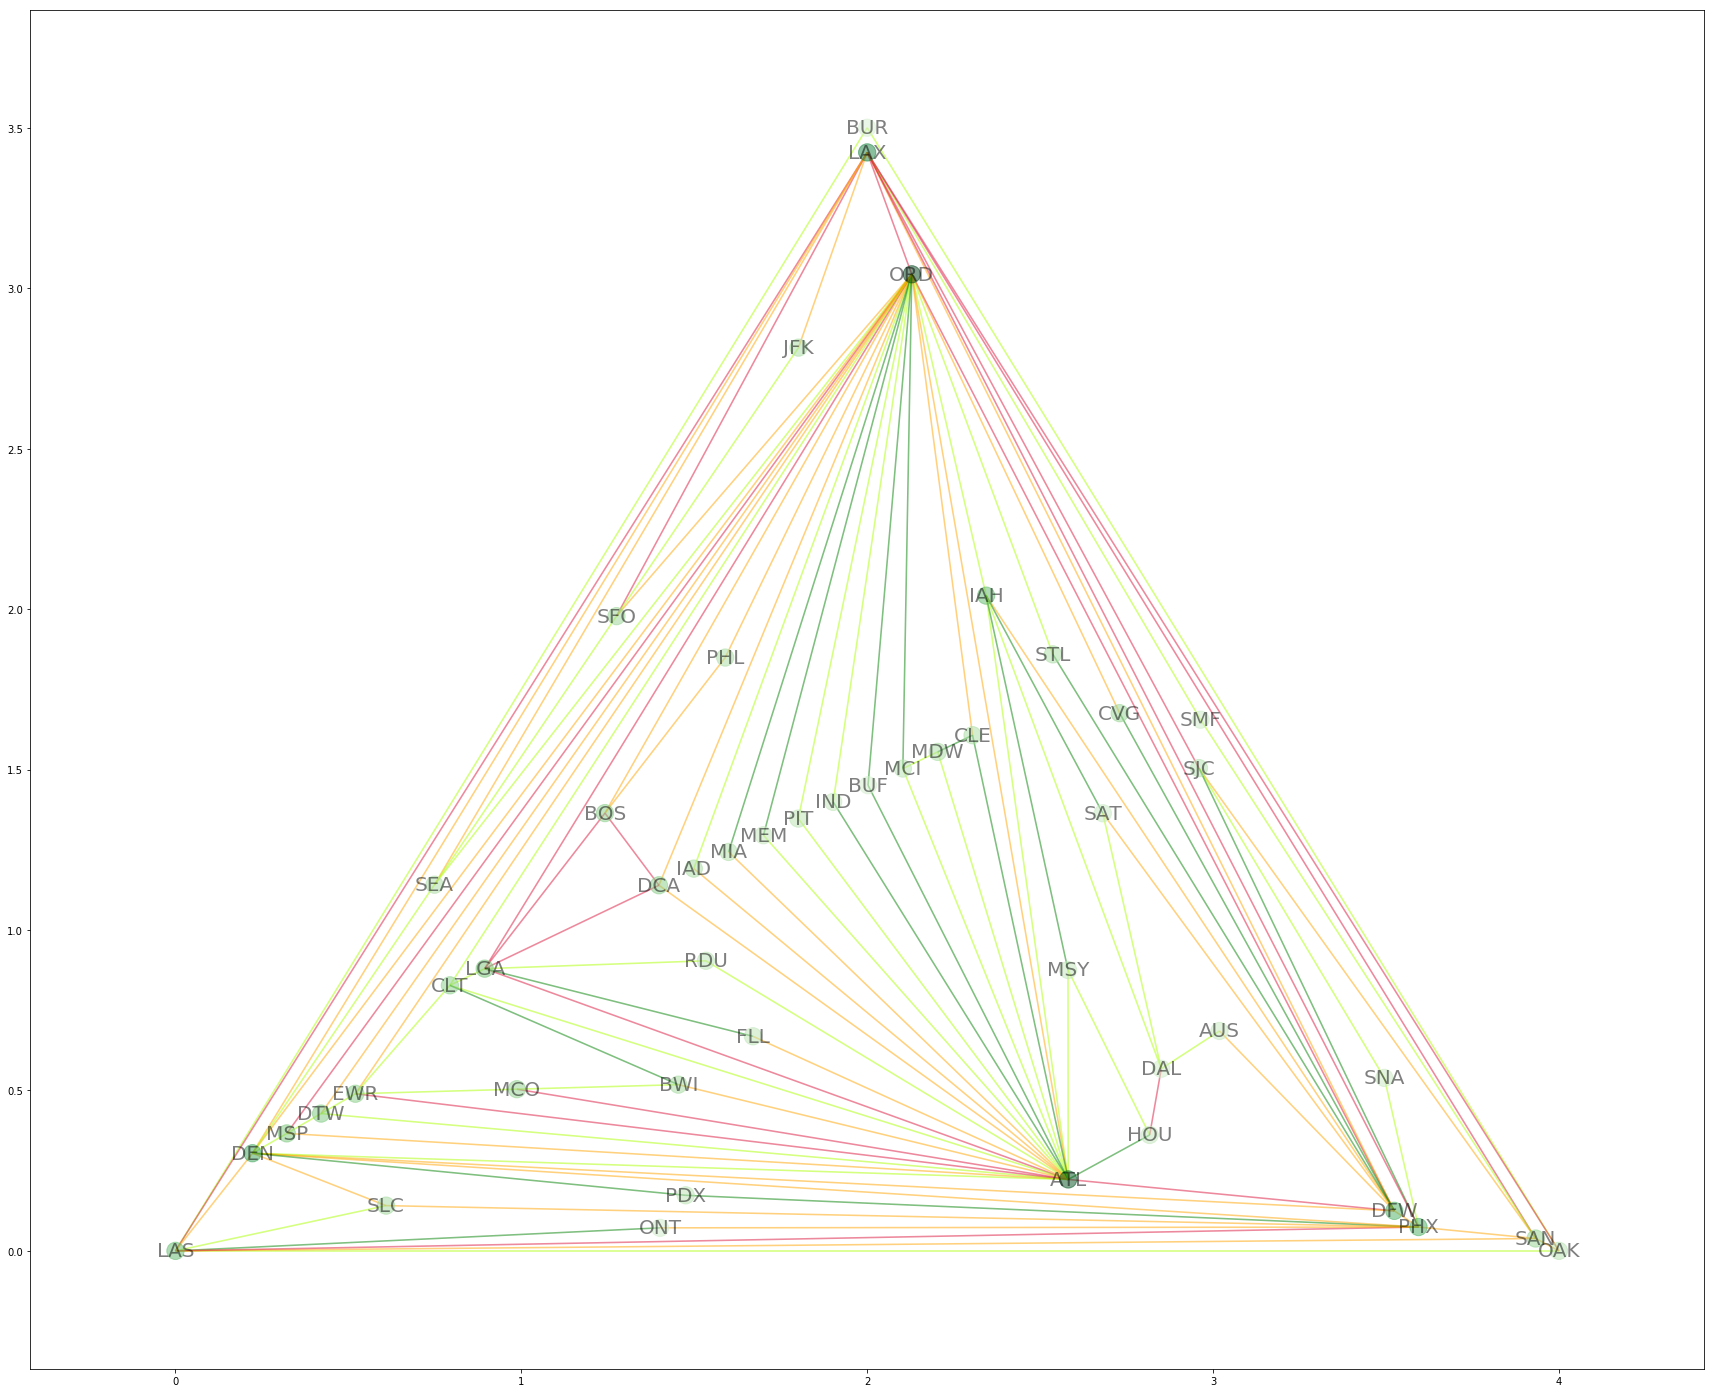

In [254]:
list_of_cities = list(set_of_cities)
list_from = []
list_to = []
list_capacity = []
for i in range(len(set_of_cities)):
    for j in range(i + 1, len(set_of_cities)):
        if (graph.incidence_matrix[list_of_cities[i]][list_of_cities[j]] >= 40000):
            list_from.append(list_of_cities[i])
            list_to.append(list_of_cities[j])
            list_capacity.append(graph.incidence_matrix[list_of_cities[i]][list_of_cities[j]])
draw_df = pd.DataFrame({"from":list_from, "to":list_to, "weight":list_capacity})
fig = plt.figure(figsize=(30,25))
NW = nx.from_pandas_dataframe(draw_df, "from", "to", create_using=nx.Graph())
dic = {}
colors = pd.Series("", index=list(NW.edges()))
for edge in list(NW.edges()):
    if (graph.incidence_matrix[edge[0]][edge[1]] > 70000):
        if (graph.incidence_matrix[edge[0]][edge[1]] > 100000):
            colors[edge] = "crimson"
        else:
            colors[edge] = "orange"
    else:
        if (graph.incidence_matrix[edge[0]][edge[1]] > 50000):
            colors[edge] = "#aaff00"
        else:
            colors[edge] = "green"
for i in set_of_cities:
    dic[i] = (X[i], Y[i])
nx.draw_networkx(NW, pos=dic, with_labels=True, node_size=300,
                 edge_color=colors, node_color=graph.incidence_matrix.loc[list(NW.nodes),
                                                                                     list(NW.nodes)].sum(),
                 cmap=plt.cm.Greens, vmin=-200000, node_shape="o", alpha=0.5, width=1.6,
                 font_size=20)